In [1]:
import numpy as np
from pandas.plotting import scatter_matrix
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
import h5py
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]
from sklearn import preprocessing
import IPython
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, auc, roc_curve, cohen_kappa_score, accuracy_score)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
kddCupTrain = pd.read_csv('kddCupTrain.csv',header=None)
print("Shape of kddCupTrain: ",kddCupTrain.shape)
print("There are any missing values: ", kddCupTrain.isnull().values.any())
print(kddCupTrain.head(3))

Shape of kddCupTrain:  (985262, 42)
There are any missing values:  False
   0    1     2   3    4      5   6   7   8   9   ...  32   33   34   35   36  \
0   0  tcp  http  SF  215  45076   0   0   0   0  ...   0  0.0  0.0  0.0  0.0   
1   0  tcp  http  SF  162   4528   0   0   0   0  ...   1  1.0  0.0  1.0  0.0   
2   0  tcp  http  SF  236   1228   0   0   0   0  ...   2  1.0  0.0  0.5  0.0   

    37   38   39   40       41  
0  0.0  0.0  0.0  0.0  normal.  
1  0.0  0.0  0.0  0.0  normal.  
2  0.0  0.0  0.0  0.0  normal.  

[3 rows x 42 columns]


In [3]:
kddCupTrain.iloc[:,-1].unique()

array(['normal.', 'ipsweep.'], dtype=object)

In [4]:
kddCupTrain.rename(columns={41:'Class'}, inplace=True)
kddCupTrain['Class'] = np.where(kddCupTrain['Class'] == 'normal.', 0, 1)

In [5]:
count_classes = pd.value_counts(kddCupTrain['Class'], sort = True)
print(count_classes)

0    972781
1     12481
Name: Class, dtype: int64


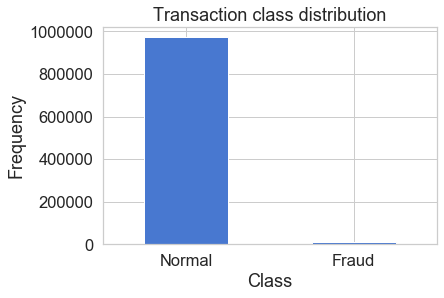

In [6]:
count_classes = pd.value_counts(kddCupTrain['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
rcParams['figure.figsize'] = 14, 8
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [9]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [13]:
print(kddCupTrain.describe(percentiles=[]))

                   0             4             5              6  \
count  985262.000000  9.852620e+05  9.852620e+05  985262.000000   
mean      215.078631  1.459258e+03  3.193730e+03       0.000007   
std      1343.633640  1.097984e+05  3.401613e+04       0.002665   
min         0.000000  0.000000e+00  0.000000e+00       0.000000   
50%         0.000000  2.300000e+02  4.060000e+02       0.000000   
max     58329.000000  8.958152e+07  1.173059e+07       1.000000   

                   8              9             10             11  \
count  985262.000000  985262.000000  985262.000000  985262.000000   
mean        0.000036       0.048908       0.000097       0.710185   
std         0.015897       0.926008       0.013058       0.453677   
min         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       1.000000   
max        14.000000      77.000000       4.000000       1.000000   

                  12             13           

In [11]:
columnsList=[7, 19]
print(columnsList)

[7, 19]


In [12]:
kddCupTrain.drop(columnsList, axis=1, inplace=True)

In [14]:
kddCupTrain = pd.get_dummies(kddCupTrain, columns = [1,2,3])
kddCupTrain.head(2)

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Class,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,0,215,45076,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,162,4528,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [15]:
kddCupTrain.shape

(985262, 84)

In [17]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [18]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
print(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [19]:
featuresList = [col for col in kddCupTrain if col != 'Class']
print('featuresList: ',featuresList)

featuresList:  [0, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, '1_icmp', '1_tcp', '1_udp', '2_IRC', '2_X11', '2_auth', '2_ctf', '2_domain', '2_domain_u', '2_eco_i', '2_ecr_i', '2_finger', '2_ftp', '2_ftp_data', '2_gopher', '2_http', '2_imap4', '2_link', '2_mtp', '2_name', '2_ntp_u', '2_other', '2_pop_3', '2_private', '2_red_i', '2_remote_job', '2_rje', '2_shell', '2_smtp', '2_ssh', '2_telnet', '2_tftp_u', '2_tim_i', '2_time', '2_urh_i', '2_urp_i', '2_whois', '3_OTH', '3_REJ', '3_RSTO', '3_RSTR', '3_S0', '3_S1', '3_S2', '3_S3', '3_SF', '3_SH']


In [20]:
featuresList = [x for x in featuresList if x!='2_tftp_u']
featuresList = [x for x in featuresList if x!='3_SH']

In [21]:
scaler = preprocessing.StandardScaler()
scaler.fit(kddCupTrain[featuresList]);

kddCupTrain[featuresList] = scaler.transform(kddCupTrain[featuresList])
kddCupTrain.head()

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,Class,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tftp_u,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF,3_SH
0,-0.160072,-0.011332,1.231248,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.409932,-2.305156,-2.774254,-0.312768,-0.490601,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,0,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,0,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,0
1,-0.160072,-0.011815,0.039225,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.343674,-0.413666,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.400319,-2.293712,0.505148,-0.312768,2.892443,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,0,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,0,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,0
2,-0.160072,-0.011141,-0.057788,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.400307,-0.459644,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.390706,-2.282268,0.505148,-0.312768,1.200921,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,0,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,0,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,0
3,-0.160072,-0.011168,-0.034152,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.343674,-0.413666,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.381093,-2.270824,0.505148,-0.312768,0.625803,-0.364928,-0.071005,-0.067659,-0.256994,-0.255699,0,-0.159086,0.529373,-0.490936,-0.022979,-0.011443,-0.048666,-0.003632,-0.007195,-0.249579,-0.125531,-0.059674,-0.071634,-0.062502,-0.200579,-0.003632,0.769121,-0.001745,-0.003632,-0.003632,-0.003632,-0.062494,-0.246691,-0.030605,-0.286121,-0.003022,-0.003632,-0.003632,-0.002253,-0.327395,-0.004506,-0.047746,0,-0.002665,-0.023024,-0.012257,-0.074063,-0.003632,-0.003632,-0.2415,-0.025415,-0.018415,-0.020749,-0.023156,-0.012462,-0.006833,0.246487,0
4,-0.160072,-0.011114,-0.079601,-0.002665,-0.002235,-0.052816,-0.007462,0.638815,-0.004408,-0.01751,-0.010097,-0.007306,-0.021144,-0.018825,-0.06415,-0.001425,-0.062026,-0.287041,-0.367688,-0.054177,-0.065379,-0.244638,-0.2471,0.157516,-0.1567,-0.486674,-1.371480,-2.259380,0.505148,-0.312768,0.355160,-0.364928,-0.071005,-0.067659,-0

In [22]:
kddCupTrain=kddCupTrain.drop(['2_tftp_u', '3_SH'],axis=1)
kddCupTrain.shape

(985262, 82)

In [23]:
X_train_split, X_test_split = train_test_split(kddCupTrain, test_size=0.2,
                                   stratify=kddCupTrain['Class'], 
                                   random_state=RANDOM_SEED)

In [24]:
print(X_train_split.shape, X_test_split.shape)

(788209, 82) (197053, 82)


In [25]:
y_train = X_train_split['Class']
X_train = X_train_split.drop(['Class'], axis=1)

y_test = X_test_split['Class']
X_test = X_test_split.drop(['Class'], axis=1)
print('Train: shape X',X_train.shape,', shape Y',y_train.shape)
print('Test: shape X',X_test.shape,', shape Y',y_test.shape)

Train: shape X (788209, 81) , shape Y (788209,)
Test: shape X (197053, 81) , shape Y (197053,)


In [26]:
X_trainNorm = X_train[y_train == 0]
X_trainNorm_val = X_trainNorm.values # Only values, axes labels removed. This is input for the Autoencoder
X_testNorm_val = X_test[y_test == 0].values # The validation data

In [27]:
print(y_train.shape)
print(X_train.shape)

(788209,)
(788209, 81)


In [28]:
X_trainNorm_val.shape

(778224, 81)

In [29]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 60
encoder_dim = 40
print(input_dim)

81


In [30]:
input_layer = Input(shape=(input_dim, ))

#first encoder layer

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
##using dropout layers
dropout_rate = 0.1  # drop ~80% (!!!) of pixels
dropout_layer = Dropout(rate=dropout_rate)(encoder1, training=True)  # training=True activates dropout during prediction
norm_1 = BatchNormalization()(dropout_layer)

#second encoder layer
encoder2 = Dense(40, activation="relu")(norm_1)

#using dropout layer
dropout_rate = 0.1
dropout_layer2 = Dropout(rate=dropout_rate)(encoder2, training=True)
norm_2 = BatchNormalization()(dropout_layer2)

#third encoder layer
encoder3 = Dense(20, activation="relu")(norm_2)

##using dropout layer
dropout_rate = 0.1
dropout_layer3 = Dropout(rate = dropout_rate)(encoder3, training=True)
norm_3 = BatchNormalization()(dropout_layer3)

##using fourth encoder layer
encoder4 = Dense(10, activation="relu")(norm_3)

##creating the first decoder layer
decoder1 = Dense(20, activation='tanh')(encoder4)

##creating the first dropout for the decoder layer
dropout_rate = 0.1
dropout_layer4 = Dropout(rate=dropout_rate)(decoder1, training=True)
norm_4 = BatchNormalization()(dropout_layer4)

##adding the second decoder layer
decoder2 = Dense(40, activation='relu')(norm_4)

##addind another dropout for decoder
dropout_rate = 0.1
dropout_layer5 = Dropout(rate=dropout_rate)(decoder2, training=True)
norm_5 = BatchNormalization()(dropout_layer5)

#adding the third decoder layer
decoder3 = Dense(60, activation="tanh")(norm_5)

#adding another dropout layer
dropout_rate = 0.1
dropout_layer6 = Dropout(rate=dropout_rate)(decoder3, training=True)
norm_6 = BatchNormalization()(dropout_layer6)

##adding 4th decoder layer
decoder4 = Dense(input_dim, activation="relu")(norm_6)

#print('input_layer: ',input_layer)
#print('encoder1',encoder1)
#print('encoder2',encoder2)
#print('decoder1',decoder1)
#print('decoder2',decoder2)


In [31]:
## Creating an autoencoder from the tensors
autoencoder = Model(inputs=input_layer, outputs=decoder4)
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 81)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                4920      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 60)                240       
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2440      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 40)               

In [32]:
nb_epoch = 100
batch_size = 500

autoencoder.compile(optimizer='adam', 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) # 'patience' number of not improving epochs
history = autoencoder.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               #earlystopping
                              ]).history

Train on 778224 samples, validate on 194557 samples
Epoch 1/100
777500/778224 [============================>.] - ETA: 0s - loss: 0.5917WARNING:tensorflow:From /opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
778224/778224 [==============================] - 23s 29us/sample - loss: 0.5919 - val_loss: 0.4742
Epoch 2/100
778224/778224 [==============================] - 21s 27us/sample - loss: 0.4854 - val_loss: 0.4445
Epoch 3/100
778224/778224 [==============================] - 22s 28us/sample - loss: 0.4617 - val_loss: 0.4275
Epoch 4/100
778224/778224 [==============================] - 22s 28us/sample - loss: 0.4505 - val_loss: 0.4217
Epoch 5/100
778224/778224 [==============================] - 22s 29us/sampl

Epoch 70/100
778224/778224 [==============================] - 19s 25us/sample - loss: 0.3857 - val_loss: 0.3643
Epoch 71/100
778224/778224 [==============================] - 22s 28us/sample - loss: 0.3846 - val_loss: 0.3672
Epoch 72/100
778224/778224 [==============================] - 22s 28us/sample - loss: 0.3853 - val_loss: 0.3712
Epoch 73/100
778224/778224 [==============================] - 16s 21us/sample - loss: 0.3867 - val_loss: 0.3676
Epoch 74/100
778224/778224 [==============================] - 16s 20us/sample - loss: 0.3849 - val_loss: 0.3676
Epoch 75/100
778224/778224 [==============================] - 15s 20us/sample - loss: 0.3856 - val_loss: 0.3668
Epoch 76/100
778224/778224 [==============================] - 16s 20us/sample - loss: 0.3846 - val_loss: 0.3703
Epoch 77/100
778224/778224 [==============================] - 17s 22us/sample - loss: 0.3837 - val_loss: 0.3676
Epoch 78/100
778224/778224 [==============================] - 21s 27us/sample - loss: 0.3859 - val_loss:

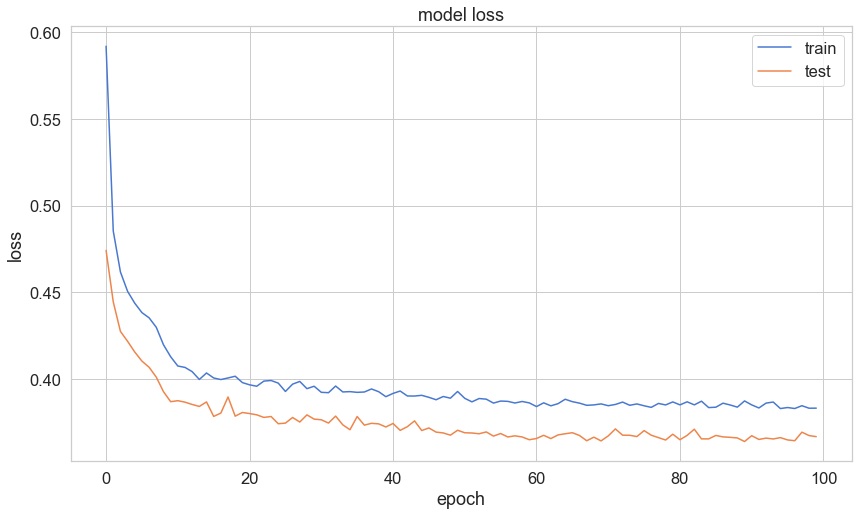

In [33]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [34]:
input_dim = X_trainNorm_val.shape[1]
layer1_dim = 40
layer3_dim = 20
encoder_dim = 10

In [35]:
input_layer = Input(shape=(input_dim, ))

dropout_rate = 0.0

encoder1 = Dense(layer1_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
dropout_layer1 = Dropout(rate=dropout_rate)(encoder1, training=True)
norm_1 = BatchNormalization()(dropout_layer1)

#encoder2 = Dense(layer2_dim, activation="relu")(norm_1)
#dropout_layer2 = Dropout(rate=dropout_rate)(encoder2, training=True)
#norm_2 = BatchNormalization()(dropout_layer2)

encoder3 = Dense(layer3_dim, activation="relu")(norm_1)
dropout_layer3 = Dropout(rate=dropout_rate)(encoder3, training=True)
norm_3 = BatchNormalization()(dropout_layer3)

encoder4 = Dense(encoder_dim, activation="relu")(norm_3)
dropout_layer4 = Dropout(rate=dropout_rate)(encoder4, training=True)
norm_4 = BatchNormalization()(dropout_layer4)

decoder1 = Dense(layer3_dim, activation='relu')(norm_4)
dropout_layer5 = Dropout(rate=dropout_rate)(decoder1, training=True)
norm_5 = BatchNormalization()(dropout_layer5)

#decoder2 = Dense(layer2_dim, activation='relu')(norm_5)
#dropout_layer6 = Dropout(rate=dropout_rate)(decoder2, training=True)
#norm_6 = BatchNormalization()(dropout_layer6)

decoder3 = Dense(layer1_dim, activation='tanh')(norm_4)
dropout_layer7 = Dropout(rate=dropout_rate)(decoder3, training=True)
norm_7 = BatchNormalization()(dropout_layer7)

decoder4 = Dense(input_dim, activation='linear')(norm_7)

print('input_layer: ',input_layer)
print('encoder1',encoder1)
#print('encoder2',encoder2)
print('encoder3',encoder3)
print('encoder4',encoder4)
print('decoder1',decoder1)
#print('decoder2',decoder2)
print('decoder3',decoder3)
print('decoder4',decoder4)

input_layer:  Tensor("input_2:0", shape=(?, 81), dtype=float32)
encoder1 Tensor("dense_8/Tanh:0", shape=(?, 40), dtype=float32)
encoder3 Tensor("dense_9/Relu:0", shape=(?, 20), dtype=float32)
encoder4 Tensor("dense_10/Relu:0", shape=(?, 10), dtype=float32)
decoder1 Tensor("dense_11/Relu:0", shape=(?, 20), dtype=float32)
decoder3 Tensor("dense_12/Tanh:0", shape=(?, 40), dtype=float32)
decoder4 Tensor("dense_13/BiasAdd:0", shape=(?, 81), dtype=float32)


In [36]:
autoencoder2 = Model(inputs=input_layer, outputs=decoder4)
autoencoder2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 81)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 40)                3280      
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 40)                160       
_________________________________________________________________
dense_9 (Dense)              (None, 20)                820       
_________________________________________________________________
dropout_7 (Dropout)          (None, 20)                0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 20)               

In [37]:
nb_epoch = 100
batch_size = 500

autoencoder2.compile(optimizer='adam', 
                    loss='mean_squared_error')

checkpointer = ModelCheckpoint(filepath="model2.h5",
                               verbose=0,
                               save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0) # 'patience' number of not improving epochs
history = autoencoder2.fit(X_trainNorm_val, X_trainNorm_val,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_testNorm_val, X_testNorm_val),
                    verbose=1,
                    callbacks=[checkpointer, #tensorboard, 
                               #earlystopping
                              ]).history

Train on 778224 samples, validate on 194557 samples
Epoch 1/100
778224/778224 [==============================] - 17s 22us/sample - loss: 0.5208 - val_loss: 0.3730
Epoch 2/100
778224/778224 [==============================] - 17s 22us/sample - loss: 0.3597 - val_loss: 0.2989
Epoch 3/100
778224/778224 [==============================] - 17s 22us/sample - loss: 0.3136 - val_loss: 0.2699
Epoch 4/100
778224/778224 [==============================] - 16s 20us/sample - loss: 0.2917 - val_loss: 0.2641
Epoch 5/100
778224/778224 [==============================] - 17s 22us/sample - loss: 0.2792 - val_loss: 0.2567
Epoch 6/100
778224/778224 [==============================] - 13s 16us/sample - loss: 0.2686 - val_loss: 0.2484
Epoch 7/100
778224/778224 [==============================] - 12s 15us/sample - loss: 0.2616 - val_loss: 0.2455
Epoch 8/100
778224/778224 [==============================] - 12s 15us/sample - loss: 0.2550 - val_loss: 0.2429
Epoch 9/100
778224/778224 [==============================] -

Epoch 74/100
778224/778224 [==============================] - 11s 14us/sample - loss: 0.1963 - val_loss: 0.2520
Epoch 75/100
778224/778224 [==============================] - 16s 21us/sample - loss: 0.1972 - val_loss: 0.2341
Epoch 76/100
778224/778224 [==============================] - 18s 23us/sample - loss: 0.1962 - val_loss: 0.2280
Epoch 77/100
778224/778224 [==============================] - 18s 23us/sample - loss: 0.1968 - val_loss: 0.2493
Epoch 78/100
778224/778224 [==============================] - 17s 22us/sample - loss: 0.1950 - val_loss: 0.2301
Epoch 79/100
778224/778224 [==============================] - 18s 23us/sample - loss: 0.1954 - val_loss: 0.2306
Epoch 80/100
778224/778224 [==============================] - 19s 25us/sample - loss: 0.1977 - val_loss: 0.2392
Epoch 81/100
778224/778224 [==============================] - 19s 24us/sample - loss: 0.1954 - val_loss: 0.2412
Epoch 82/100
778224/778224 [==============================] - 19s 24us/sample - loss: 0.1954 - val_loss:

In [38]:
### finding the minimum vaidation loss from the above algorithm and then use that optimal number of epochs
min(history['val_loss'])

0.21191905041502124

In [39]:
autoencoder = load_model('model2.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


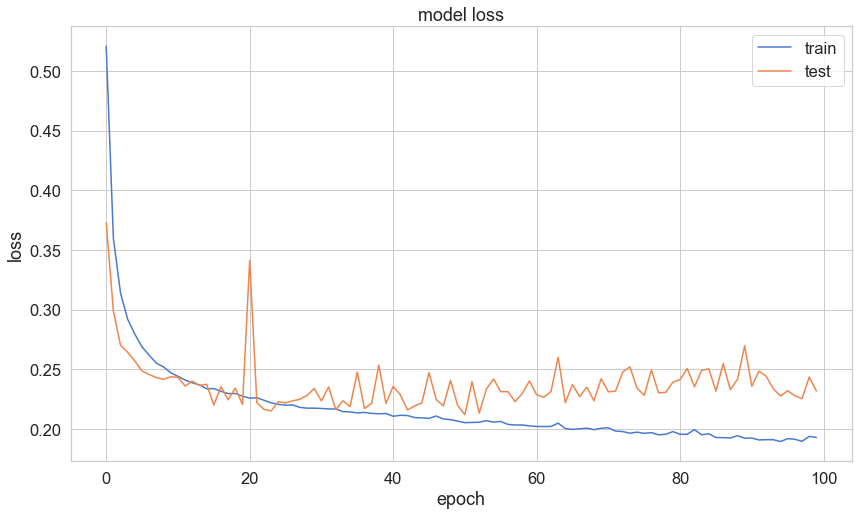

In [40]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [41]:
testPredictions = autoencoder.predict(X_test)
X_test.shape,testPredictions.shape

((197053, 81), (197053, 81))

In [42]:
testMSE = mean_squared_error(X_test.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')
error_df = pd.DataFrame({'reconstruction_error': testMSE,'true_class': y_test})
error_df.head()

,reconstruction_error,true_class
940543,0.230448,1
356110,0.051513,0
540178,0.008920,0
672514,0.022151,0
244980,0.009780,0


In [43]:
error_df.shape

(197053, 2)

In [44]:
error_df.reconstruction_error.describe()

count    197053.000000
mean          0.321598
std          27.203051
min           0.004738
25%           0.009199
50%           0.012861
75%           0.031681
max        8862.735674
Name: reconstruction_error, dtype: float64

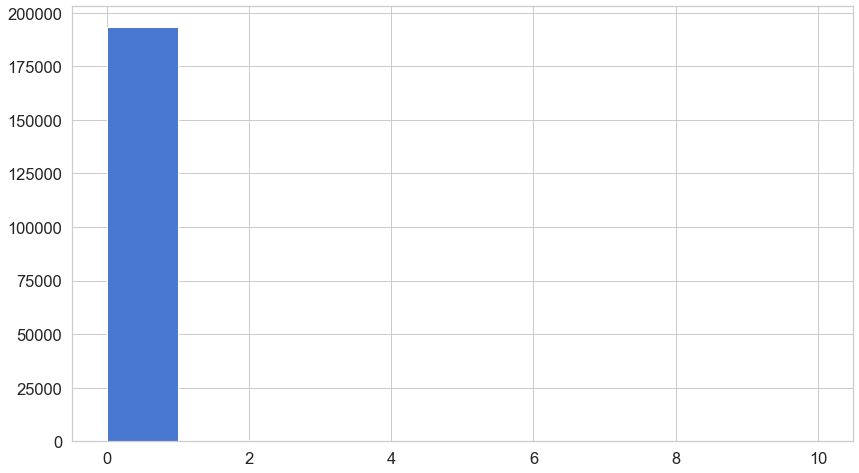

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
ax.hist(normal_error_df.reconstruction_error.values, bins=10);

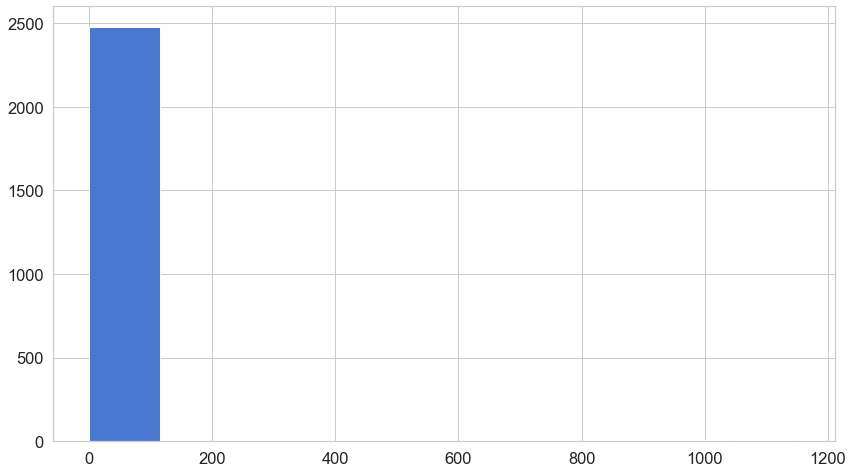

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
ax.hist(fraud_error_df.reconstruction_error.values, bins=10);

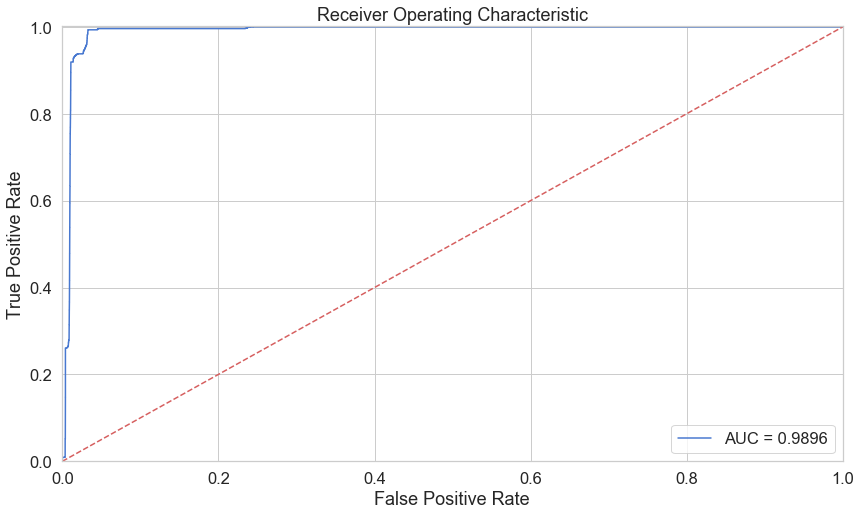

In [47]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [48]:
threshold = normal_error_df.reconstruction_error.quantile(q=0.995)
threshold

1.0261473519537232

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


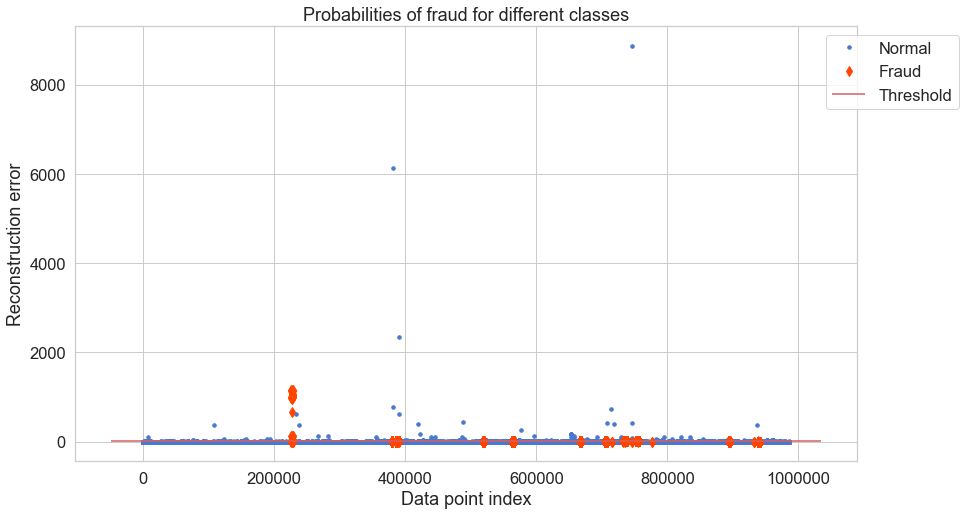

In [49]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()
for name, group in groups:
    if name == 1:
        MarkerSize = 7
        Color = 'orangered'
        Label = 'Fraud'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(loc='upper left', bbox_to_anchor=(0.95, 1))
plt.title("Probabilities of fraud for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

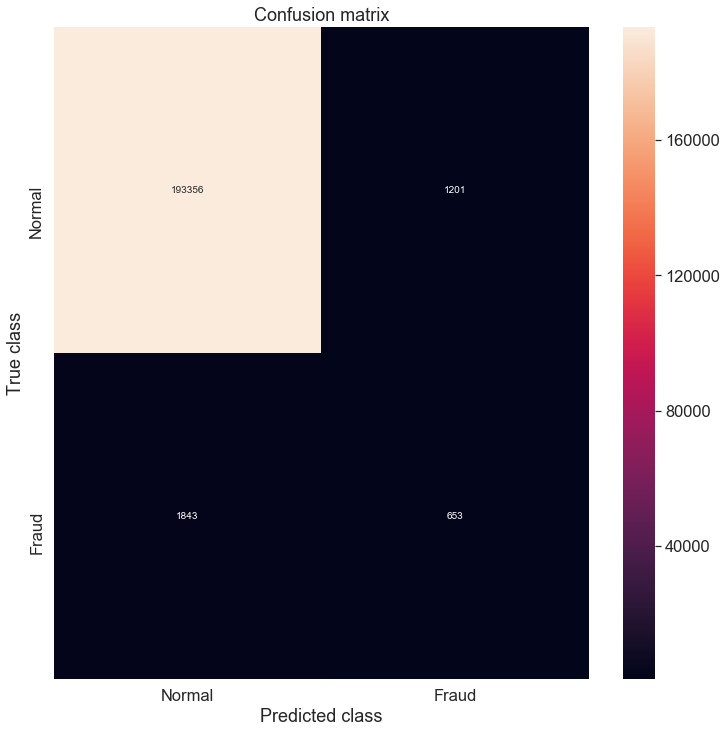

In [50]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [51]:
cohen_kappa_score(error_df.true_class, y_pred),accuracy_score(error_df.true_class, y_pred)

(0.29259184271004635, 0.9845523793091199)

In [52]:
kddCupTest = pd.read_csv('kddCupTest.csv', header=None)
print(kddCupTest.head(3))

   0    1        2   3     4      5   6   7   8   9   10  11  12  13  14  15  \
0   0  tcp     http  SF   230  10066   0   0   0   0   0   1   0   0   0   0   
1   0  udp  private  SF   105    145   0   0   0   0   0   0   0   0   0   0   
2   1  tcp     smtp  SF  1888    374   0   0   0   0   0   1   0   0   0   0   

   16  17  18  19  20  21  22  23   24   25   26   27   28   29   30   31  \
0   0   0   0   0   0   0  19  20  0.0  0.0  0.0  0.0  1.0  0.0  0.1  255   
1   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   
2   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  255   

    32    33    34   35   36   37   38   39   40  
0  255  1.00  0.00  0.0  0.0  0.0  0.0  0.0  0.0  
1  227  0.89  0.01  0.0  0.0  0.0  0.0  0.0  0.0  
2  174  0.68  0.03  0.0  0.0  0.0  0.0  0.0  0.0  


In [53]:
kddCupTest.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40],
           dtype='int64')

In [54]:
kddCupTest.shape

(196557, 41)

In [55]:
##removing the uninformative columns as we did before for the training data set
kddCupTest.drop(columnsList, axis=1, inplace=True)
kddCupTest.shape

(196557, 39)

In [56]:
kddCupTest = pd.get_dummies(kddCupTest, columns = [1,2,3])
kddCupTest.head(2)
kddCupTest.shape

(196557, 106)

In [57]:
len(featuresList)

81

In [58]:
kddCupTest = kddCupTest[featuresList]

In [59]:
scaler = preprocessing.StandardScaler()
scaler.fit(kddCupTest);

In [60]:
kddCupTest.shape

(196557, 81)

In [61]:
kddCupTest[featuresList] = scaler.transform(kddCupTest[featuresList])

In [62]:
kddCupTest.head()

,0,4,5,6,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,1_icmp,1_tcp,1_udp,2_IRC,2_X11,2_auth,2_ctf,2_domain,2_domain_u,2_eco_i,2_ecr_i,2_finger,2_ftp,2_ftp_data,2_gopher,2_http,2_imap4,2_link,2_mtp,2_name,2_ntp_u,2_other,2_pop_3,2_private,2_red_i,2_remote_job,2_rje,2_shell,2_smtp,2_ssh,2_telnet,2_tim_i,2_time,2_urh_i,2_urp_i,2_whois,3_OTH,3_REJ,3_RSTO,3_RSTR,3_S0,3_S1,3_S2,3_S3,3_SF
0,-0.161814,-0.021112,0.213319,0.0,-0.0034,-0.051868,-0.007121,0.636295,-0.006817,-0.016577,-0.008353,-0.014751,-0.022006,-0.018474,-0.064548,0.0,-0.060887,0.134005,0.420353,-0.079142,-0.066255,-0.267438,-0.268099,0.182557,-0.186294,-0.114078,1.022195,0.618991,0.518273,-0.326291,-0.477196,-0.478362,-0.093822,-0.056797,-0.277705,-0.276267,-0.116903,0.511293,-0.490231,-0.022786,-0.01058,-0.048591,-0.002256,-0.007133,-0.250193,-0.063201,-0.059912,-0.071185,-0.061349,-0.200469,-0.004511,0.764834,-0.002256,-0.002256,-0.002256,-0.002256,-0.063404,-0.263640,-0.031915,-0.286957,-0.002256,-0.002256,-0.002256,-0.004511,-0.328035,-0.002256,-0.047204,-0.003907,-0.022786,-0.012147,-0.076108,-0.002256,-0.003907,-0.262899,-0.025427,-0.017763,-0.032937,-0.024613,-0.01276,-0.007133,0.269105
1,-0.161814,-0.023648,-0.095420,0.0,-0.0034,-0.051868,-0.007121,-1.571597,-0.006817,-0.016577,-0.008353,-0.014751,-0.022006,-0.018474,-0.064548,0.0,-0.060887,-0.236701,-0.451226,-0.079142,-0.066255,-0.267438,-0.268099,0.182557,-0.186294,-0.477174,1.022195,0.304009,0.169639,-0.276441,-0.477196,-0.478362,-0.093822,-0.056797,-0.277705,-0.276267,-0.116903,-1.955827,2.039855,-0.022786,-0.01058,-0.048591,-0.002256,-0.007133,-0.250193,-0.063201,-0.059912,-0.071185,-0.061349,-0.200469,-0.004511,-1.307473,-0.002256,-0.002256,-0.002256,-0.002256,-0.063404,-0.263640,-0.031915,3.484840,-0.002256,-0.002256,-0.002256,-0.004511,-0.328035,-0.002256,-0.047204,-0.003907,-0.022786,-0.012147,-0.076108,-0.002256,-0.003907,-0.262899,-0.025427,-0.017763,-0.032937,-0.024613,-0.01276,-0.007133,0.269105
2,-0.161069,0.012523,-0.088293,0.0,-0.0034,-0.051868,-0.007121,0.636295,-0.006817,-0.016577,-0.008353,-0.014751,-0.022006,-0.018474,-0.064548,0.0,-0.060887,-0.236701,-0.451226,-0.079142,-0.066255,-0.267438,-0.268099,0.182557,-0.186294,-0.477174,1.022195,-0.292208,-0.495935,-0.176742,-0.477196,-0.478362,-0.093822,-0.056797,-0.277705,-0.276267,-0.116903,0.511293,-0.490231,-0.022786,-0.01058,-0.048591,-0.002256,-0.007133,-0.250193,-0.063201,-0.059912,-0.071185,-0.061349,-0.200469,-0.004511,-1.307473,-0.002256,-0.002256,-0.002256,-0.002256,-0.063404,-0.263640,-0.031915,-0.286957,-0.002256,-0.002256,-0.002256,-0.004511,3.048458,-0.002256,-0.047204,-0.003907,-0.022786,-0.012147,-0.076108,-0.002256,-0.003907,-0.262899,-0.025427,-0.017763,-0.032937,-0.024613,-0.01276,-0.007133,0.269105
3,-0.161814,-0.019083,-0.053968,0.0,-0.0034,-0.051868,-0.007121,0.636295,-0.006817,-0.016577,-0.008353,-0.014751,-0.022006,-0.018474,-0.064548,0.0,-0.060887,-0.071943,-0.084246,-0.079142,-0.066255,-0.267438,-0.268099,0.182557,-0.186294,-0.477174,-0.533597,0.618991,0.518273,-0.326291,-0.441748,0.115093,0.257463,-0.056797,-0.277705,-0.276267,-0.116903,0.511293,-0.490231,-0.022786,-0.01058,-0.048591,-0.002256,-0.007133,-0.250193,-0.063201,-0.059912,-0.071185,-0.061349,-0.200469,-0.004511,0.764834,-0.002256,-0.002256,-0.002256,-0.002256,-0.063404,-0.263640,-0.031915,-0.286957,-0.002256,-0.002256,-0.002256,-0.004511,-0.328035,-0.002256,-0.047204,-0.003907,-0.022786,-0.012147,-0.076108,-0.002256,-0.003907,-0.262899,-0.025427,-0.017763,-0.032937,-0.024613,-0.01276,-0.007133,0.269105
4,1.794381,-0.022816,-0.096664,0.0,-0.0034,-0.051868,-0.007121,-1.571597,-0.006817,-0.016577,-0.008353,-0.014751,-0.022006,-0.018474,-0.064548,0.0,-0.060887,-0.174916,-0.405354,-0.079142,-0.066255,-0.267438,-0.268099,-3.534337,3.112102,-0.477174,1.022195,-2.227098,-2.619434,4.010604,3.067613,-0.478362,-0.093822,-0.056797,-0.277705,-0.276267,-0.116903,-1.955827,2.039855,-0.022786,-0.01058,-0.048591,-0.002256,-0.00

In [63]:

testMSE

array([0.23044757, 0.05151323, 0.00891974, ..., 0.01165165, 0.0072965 ,
       0.52337929])

In [64]:
testPredictions = autoencoder2.predict(kddCupTest)

testMSE = mean_squared_error(kddCupTest.transpose(), testPredictions.transpose(),
                              multioutput='raw_values')

In [65]:
result_df = pd.DataFrame({'reconstruction_error': testMSE})
result_df.to_csv('result.csv')

In [66]:

result_df.head()

,reconstruction_error
0,0.013942
1,0.005284
2,0.039304
3,0.014643
4,0.019456
